In [217]:
import os
import copy
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# 任务一: 生成train/test.txt

## A. 画出人脸边框以及相应关键点

In [358]:
root = os.getcwd()

In [276]:
data_root = root + "\\data"
datasets = ['I', 'II']
for dataset in datasets:   
    names = os.listdir(data_root + "\\" + dataset)
    file= open("filename_{}.txt".format(dataset), 'w')
    for name in names:
        if ".txt" not in name:    
            file.write(data_root + "/" + dataset + "/" + name + '\n')
    file.close()

path = [root + "\\data\\I", root + "\\data\\II"]
names = os.listdir(path[0]) + os.listdir(path[1])
name_file= open("filename.txt", 'w')
for name in names:
    if ".txt" not in name:    
        name_file.write(path[0] + "\\" + name + '\n')
name_file.close()

### 1. 首先画一下第一张图片的边框和关键点

In [216]:
path = data_root + "\\" + "I"
filepath = path + "\\" + "label.txt"
file = np.loadtxt(filepath, dtype=np.str)
info = file[0]
# print(info)
img_path = path + "\\" + info[0]
img = Image.open(img_path)
print(img.size)

(310, 211)


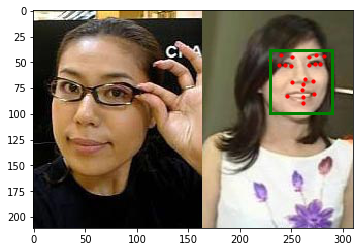

In [112]:
bbox = info[1:5].astype(np.float32)
x1, y1 = bbox[0:2]  # 左上角
x2, y2 = bbox[2:4]  # 右下角
keypoints = info[5:47].astype(np.float32).reshape(21, 2)

plt.imshow(img)
plt.gca().add_patch(  # 获取当前子图plt.gca(): Get Current Axes
    plt.Rectangle(xy=(x1, y1), width=x2-x1, height=y2-y1,
                 fill=False, edgecolor='g', linewidth=3))
for x, y in keypoints:
    plt.gca().scatter(x, y, c='r', s=10)

### 2. 画图检验标注数据

In [348]:
def draw(img_path, info):
    img = Image.open(img_path)
    img_name = info[0]
    print(img_name)
    bbox = info[1:5].astype(np.float32)
    x1, y1 = bbox[0:2]  # 左上角
    x2, y2 = bbox[2:4]  # 右下角
    keypoints = info[5:47].astype(np.float32).reshape(21, 2)
    plt.figure()
    plt.imshow(img)
    plt.title(img_name)
    plt.gca().add_patch(  # 获取当前子图plt.gca(): Get Current Axes
        plt.Rectangle(xy=(x1, y1), width=x2 - x1, height=y2 - y1,
                      fill=False, edgecolor='g', linewidth=3))
    for x, y in keypoints:
        plt.gca().scatter(x, y, c='r', s=10)
    plt.show()

def draw_crop(img_path, info):
    img = Image.open(img_path)
    img_name = info[0]
    print(img_name)
    x1, y1, x2, y2 = info[1:5].astype(np.float32)
    roi = (x1, y1, x2, y2)
    crop = img.crop(roi)
    keypoints = info[5:47].astype(np.float32).reshape(21, 2)
    plt.figure()
    plt.imshow(crop)
    plt.title(img_name)
    for x, y in keypoints:
        plt.gca().scatter(x, y, c='r', s=10)
    plt.show()


def random_draw(file_path, crop=False, shuffle=True, seed=None):
    """
    随机选取一张图片显示, 画出相应人脸边框和关键点.
    :param file_path: 标注信息文件地址
    :param crop: bool类型, 是否只画出用人脸边框截取的部分
    :param shuffle: 图片是否随机选取, 否则按标注信息顺序显示
    :param seed: 设定随机种子
    :return: 函数迭代器
    """
    file = np.loadtxt(file_path, dtype=np.str)
    idx = -1
    if seed is not None:
        np.random.seed(seed)
    while True:
        if shuffle:
            idx = np.random.randint(0, len(file) - 1)
        else:
            idx += 1
        info = file[idx]
        img_path = root + "\\data\\" + "I\\" + info[0]
        if not os.path.exists(img_path):
            img_path = root + "\\data\\" + "II\\" + info[0]
        if os.path.exists(img_path):
            if not crop:
                draw(img_path, info)
            else:
                draw_crop(img_path, info)
        else:
            print("Image {} does not exist!".format(info[0]))
        yield

In [284]:
file_path = root + "\\data\\I\\" + "label.txt" 
RD = random_draw(file_path)

**运行`next(RD)`, 每次随机绘图**:

003279.jpg


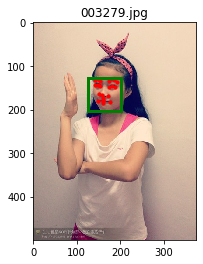

In [285]:
next(RD)

**检查发现，有些图的人脸边框和关键点虽然位置正确但是超出了图片范围。处理方式是$\color{orange}{直接不要}$啦~   
⭐由此可见，检验标注数据是否正确还是很重要的！⭐**

004237.jpg


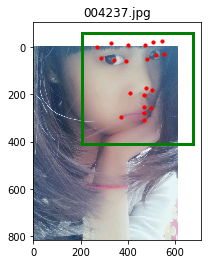

In [131]:
next(RD)

005783.jpg


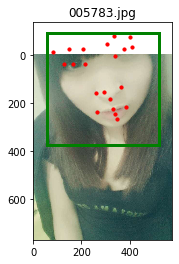

In [134]:
next(RD)

## B. 适当扩大人脸边框的范围, 获取expand后的人脸边框坐标

**扩大之前，首先判断标注数据是否正确，只保留正确的，不正确的在这一步剔除掉。**

### 1. 首先看一下上面标注不正确的信息是什么情况：

In [189]:
err_path = data_root + "\\" + "I" + "\\" + "005783.jpg"
file = np.loadtxt(data_root + "\\" + "I" + "\\" + "label.txt", dtype=np.str)
info = file[file[:, 0] == "005783.jpg"][0]
print(info[1:5])  # bounder: y1为负值,向上超出边界

['57.0' '-91.0' '521.0' '373.0']


### 2. 画图检验一下:

In [230]:
def expand_bounder(root, dataset, seed=None):
    path = root + "\\data" + "\\" + dataset
    file = np.loadtxt(path + "\\" + "label.txt", dtype=np.str)
    if seed is not None:
        np.random.seed(seed)
    while True:
        idx = np.random.randint(0, len(file) - 1)
        info = file[idx]
        img_path = path + "\\" + info[0]
        if os.path.exists(img_path):  
            print("Draw original image:")
            draw(img_path, info)

            img = Image.open(img_path)
            w, h = img.size     
            keypoints = info[5:47].astype(np.float32).reshape(21, 2)
            x1, y1, x2, y2 = info[1:5].astype(np.float32)  # 左上角, 右下角
            if not (np.any(keypoints < 0) or np.any(keypoints[:, 0] >= h) or np.any(keypoints[:, 1] >= w)):            
                b_w, b_h = x2 - x1, y2 - y1
                e_x1, e_y1, e_x2, e_y2 = x1 - 0.25 * b_w, y1 - 0.25 * b_h, x2 + 0.25 * b_w, y2 + 0.25 * b_h
                if (0 <= e_x1 < e_x2 < w and 0 <= e_y1 < e_y2 < h):
                    info[1:5] = np.array([e_x1, e_y1, e_x2, e_y2]).astype(np.str)
                    print("Draw expanded bounders:")
                    draw(img_path, info)
                else:
                    print("Expanding bounders will exceed image boundaries!")
            else:
                print("Keypoint coordinates exceed image boundaries!") 
        else:
            print("Image {} does not exist!".format(img_path))
        yield       

In [174]:
EB = expand_bounder(root, "I")

Draw original image:
004076.jpg


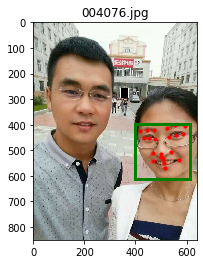

Expanding bounders will exceed image boundaries!


In [171]:
next(EB)

Draw original image:
004339.jpg


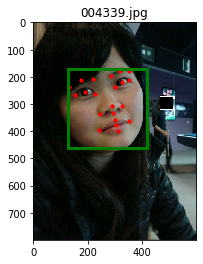

Draw expanded bounders:
004339.jpg


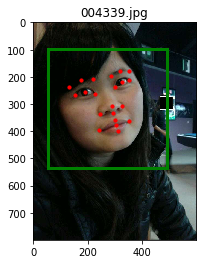

In [175]:
next(EB)

## C. 获取用expanded人脸边框截取后的人脸关键点坐标

In [242]:
def _get_expanded_info(src_file, path, idx):
    info = copy.deepcopy(src_file[idx])
    img_path = path + "\\" + info[0]
    if not os.path.exists(img_path):
        return None
    img = Image.open(img_path)
    w, h = img.size     
    keypoints = info[5:47].astype(np.float32).reshape(21, 2)
    x1, y1, x2, y2 = info[1:5].astype(np.float32)  # 左上角, 右下角
    if np.any(keypoints < 0) or np.any(keypoints[:, 0] >= h) or np.any(keypoints[:, 1] >= w):
        return None            
    b_w, b_h = x2 - x1, y2 - y1
    e_x1, e_y1, e_x2, e_y2 = x1 - 0.25 * b_w, y1 - 0.25 * b_h, x2 + 0.25 * b_w, y2 + 0.25 * b_h
    if not (0 <= e_x1 < e_x2 < w and 0 <= e_y1 < e_y2 < h):
        return None  
    info[1:5] = np.array([e_x1, e_y1, e_x2, e_y2]).astype(np.str)
    keypoints -= np.array([e_x1, e_y1])
    info[5:47] = keypoints.ravel().astype(np.str)
    return info

In [221]:
path = data_root + "\\I"
file = np.loadtxt(path + "\\label.txt", dtype=np.str)
idx = np.argwhere(file[:, 0] == "004339.jpg").ravel()[0]
print(file[idx])
print(_get_expanded_info(file, path, idx))

['004339.jpg' '128.0' '172.0' '419.0' '463.0' '133.05636070853'
 '235.99033816425' '175.15619967794' '211.61674718196' '220.57971014493'
 '206.63123993559' '287.05314009662' '196.66022544283' '319.18196457327'
 '178.93397745572' '353.52657004831' '177.82608695652' '155.21417069243'
 '268.1191626409' '227.78099838969' '261.47181964573' '301.45571658615'
 '237.65217391304' '351.31078904992' '212.17069243156' '247.1690821256'
 '338.47020933977' '293.14653784219' '334.038647343' '327.49114331723'
 '308.55716586151' '301.45571658615' '359.52012882448' '304.77938808374'
 '377.80032206119' '313.0885668277' '398.85024154589' '191.22061191626'
 '257.04025764895' '325.27536231884' '219.37198067633' '288.71497584541'
 '307.44927536232' '240.53796386719' '397.34750366211' '351.94281005859'
 '364.17779541016']
['004339.jpg' '55.25' '99.25' '491.75' '535.75' '77.806366' '136.74034'
 '119.906204' '112.366745' '165.32971' '107.38124' '231.80313' '97.41023'
 '263.93198' '79.683975' '298.27658' '78.5760

## D. 按比例生成训练与测试数据, 获取train.txt和test.txt

In [325]:
def get_expanded_info(root, info):
    img_name = info[0]
    img_path = root + "\\data\\" + "I\\" + img_name
    if not os.path.exists(img_path):
        img_path = root + "\\data\\" + "II\\" + img_name
    if not os.path.exists(img_path):
        return None

    img = Image.open(img_path)
    w, h = img.size

    keypoints = info[5:47].astype(np.float32).reshape(21, 2)
    x1, y1, x2, y2 = info[1:5].astype(np.float32)  # 左上角, 右下角
    if np.any(keypoints < 0) or np.any(keypoints[:, 0] >= h) or np.any(keypoints[:, 1] >= w):
        return None
    b_w, b_h = x2 - x1, y2 - y1
    e_x1, e_y1, e_x2, e_y2 = x1 - 0.25 * b_w, y1 - 0.25 * b_h, x2 + 0.25 * b_w, y2 + 0.25 * b_h
    if not (0 <= e_x1 < e_x2 < w and 0 <= e_y1 < e_y2 < h):
        return None

    info[1:5] = np.array([e_x1, e_y1, e_x2, e_y2]).astype(np.str)
    keypoints -= np.array([e_x1, e_y1])
    info[5:47] = keypoints.ravel().astype(np.str)
    return info


def generate_train_test(root, test_ratio=0.3):
    path = [root + "\\data\\I", root + "\\data\\II"]
    src = np.r_[np.loadtxt(path[0] + "\\" + "label.txt", dtype=np.str),
                np.loadtxt(path[1] + "\\" + "label.txt", dtype=np.str)]
    n = src.shape[0]
    src = src[np.random.shuffle(list(range(n)))][0]
    print("Total data size: ", n)

    del_idx = []
    train_size = int(n * (1 - test_ratio))
    print("Training size: ", train_size)
    if not os.path.exists("train.txt"):
        train_file = open("train.txt", 'w')
        for idx in range(train_size):
            tmp = copy.deepcopy(src[idx])
            info = get_expanded_info(root, tmp)
            if info is None:
                del_idx.append(idx)
                continue
            str_info = ''
            for i in info:
                str_info += i + " "
            train_file.write(str_info[:-1] + '\n')
        train_file.close()

    print("Test size: ", n - train_size)
    if not os.path.exists("test.txt"):
        test_file = open("test.txt", 'w')
        for idx in range(train_size, n):
            tmp = copy.deepcopy(src[idx])
            info = get_expanded_info(root, tmp)
            if info is None:
                del_idx.append(idx)
                continue
            str_info = ''
            for i in info:
                str_info += i + " "
            test_file.write(str_info[:-1] + '\n')
        test_file.close()

    remain_idx = [i for i in list(range(n)) if i not in del_idx]
    remain = src[remain_idx]
    if not os.path.exists("all.txt"):
        file = open("all.txt", 'w')
        for line in remain:
            str_line = ''
            for i in line:
                str_line += i + " "
            file.write(str_line[:-1] + '\n')
        file.close()

In [326]:
generate_train_test(root)

Total data size:  2786
Training size:  1950
Test size:  836


**这里的size只是理论上计算出来的，由于两个label.txt中记录的图片可能有重叠，或者不存在，又或者不满足expand要求，  
因此实际数据集要小于此处计算结果。**

## E. 对生成的数据进行验证

In [301]:
tra_cropper = random_draw("train.txt", crop=True)

001140.jpg


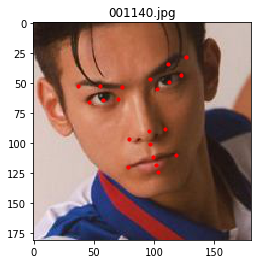

In [310]:
next(tra_cropper)

001452.jpg


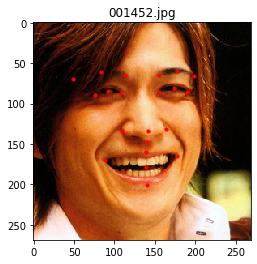

In [311]:
next(tra_cropper)

In [349]:
tra_painter = random_draw("all.txt", crop=False, shuffle=False)
tra_cropper = random_draw("train.txt", crop=True, shuffle=False)

001658.jpg


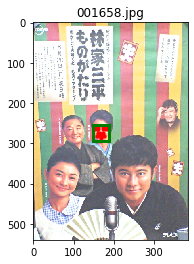

001658.jpg


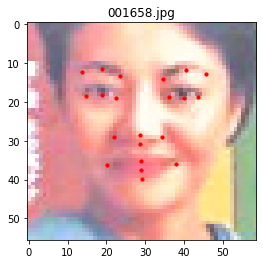

In [357]:
next(tra_painter)
next(tra_cropper)